In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "./input"]).decode("utf8"))
#print(check_output(["ls", "../input/stage1_train/"]).decode("utf8"))

stage1_test
stage1_test.zip
stage1_train
stage1_train.zip



In [2]:
#y_train = pd.read_csv('../input/stage1_train_labels.csv')
#print(y_train['EncodedPixels'])
#print(y_train.iloc[6]['EncodedPixels'])

In [3]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import os
from tqdm import tqdm
from skimage.transform import resize
%matplotlib inline

In [123]:
image_heigth = 572
image_width = 572

mask_heigth = 388
mask_width = 388

def get_images_masks():

    images = []
    root_dir = "./input/stage1_train/"
    for image_folder in tqdm(os.listdir(root_dir)):
        image_id = image_folder
        image_dir = root_dir + image_folder
        image_file = image_dir + '/images/' + image_id + '.png'
        image = mpimg.imread(image_file)
        image = resize(image, (image_heigth, image_width), mode='constant', preserve_range=True)
        masks = np.zeros((mask_heigth,mask_width))
        masks_dir = image_dir + '/masks/'
        
        for mask in os.listdir(masks_dir):
            mask_file = masks_dir + mask
            mask = mpimg.imread(mask_file)
            mask = resize(mask, (mask_heigth,mask_width), mode='constant', preserve_range=True)
            masks = np.add(masks,mask)
        
        images.append({'image_id': image_id, 'image': image,'masks': masks })
        
    return images

def plot_images(rows,cols,images):
    image_index = 0
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30,30))
    for r in range(rows):
        for c in range(cols):
            ax[r][c].imshow(images[image_index])
            image_index += 1

In [124]:
images = get_images_masks()

100%|██████████| 670/670 [04:05<00:00,  2.73it/s]


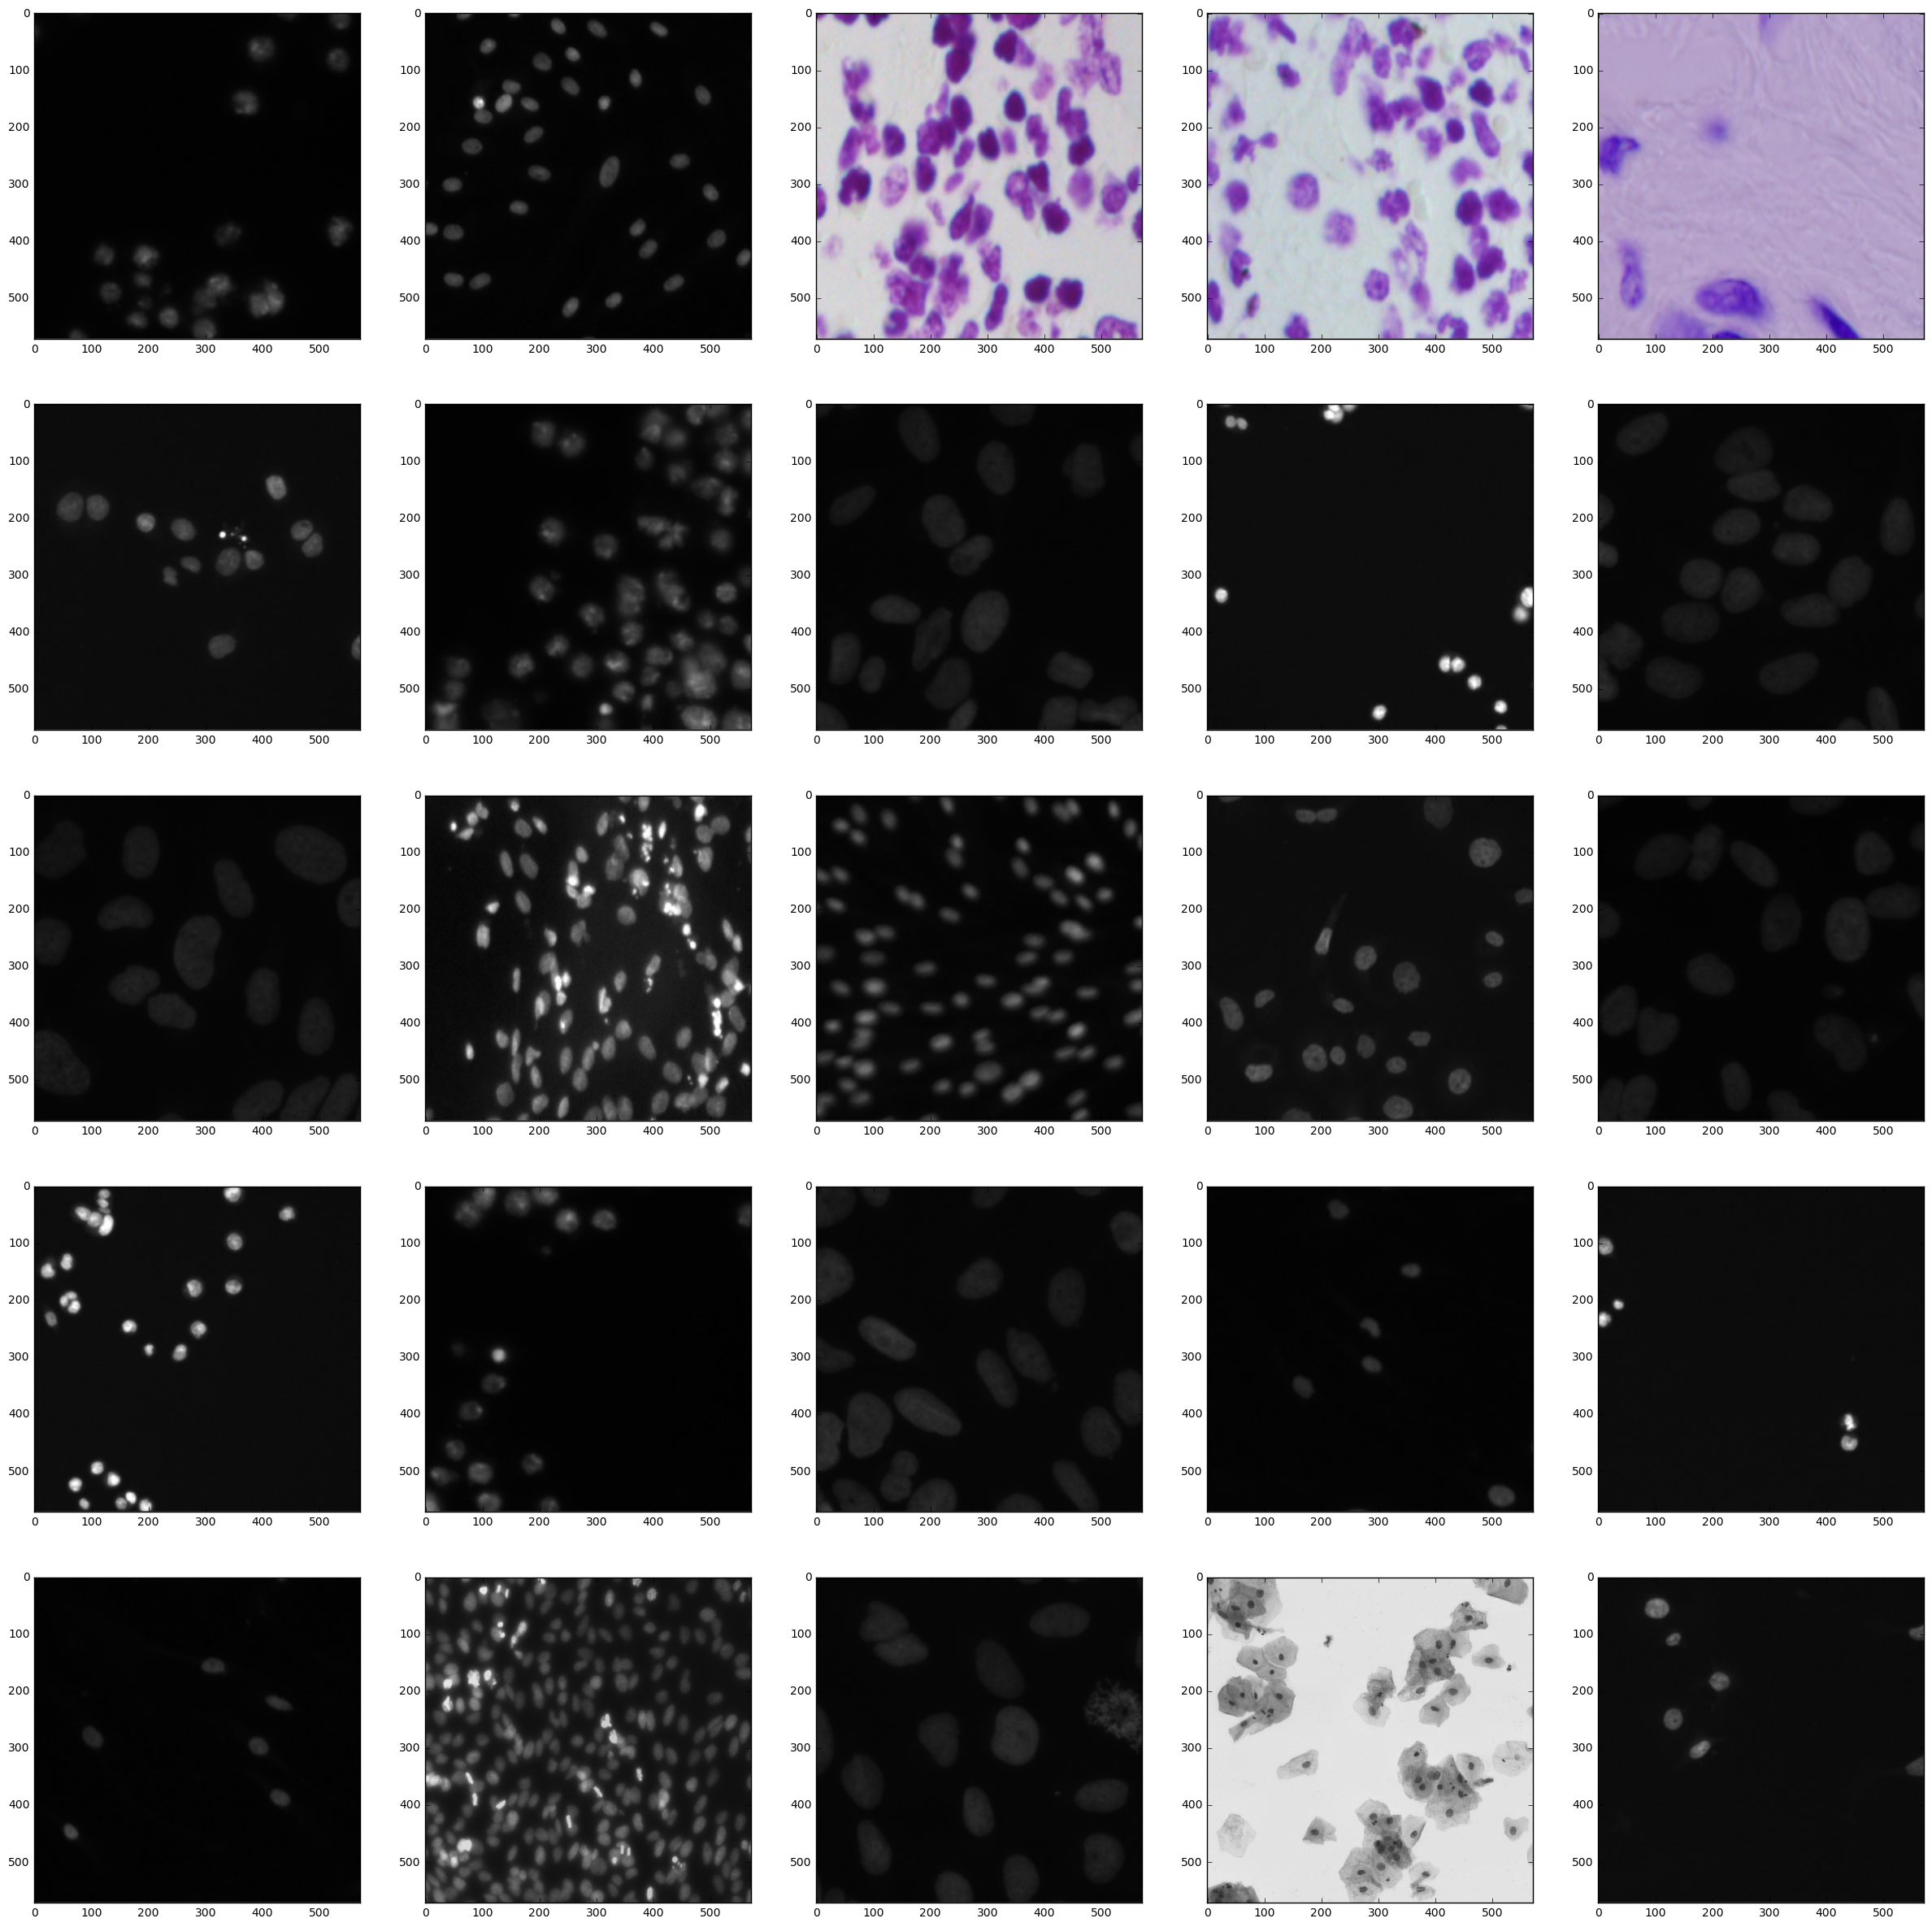

In [126]:
images_array = [image['image'] for image in images]
plot_images(rows=5,cols=5,images=images_array)

In [127]:
X_train = np.array(images_array).reshape(670,image_heigth,image_width,4)
print(X_train.shape)

(670, 572, 572, 4)


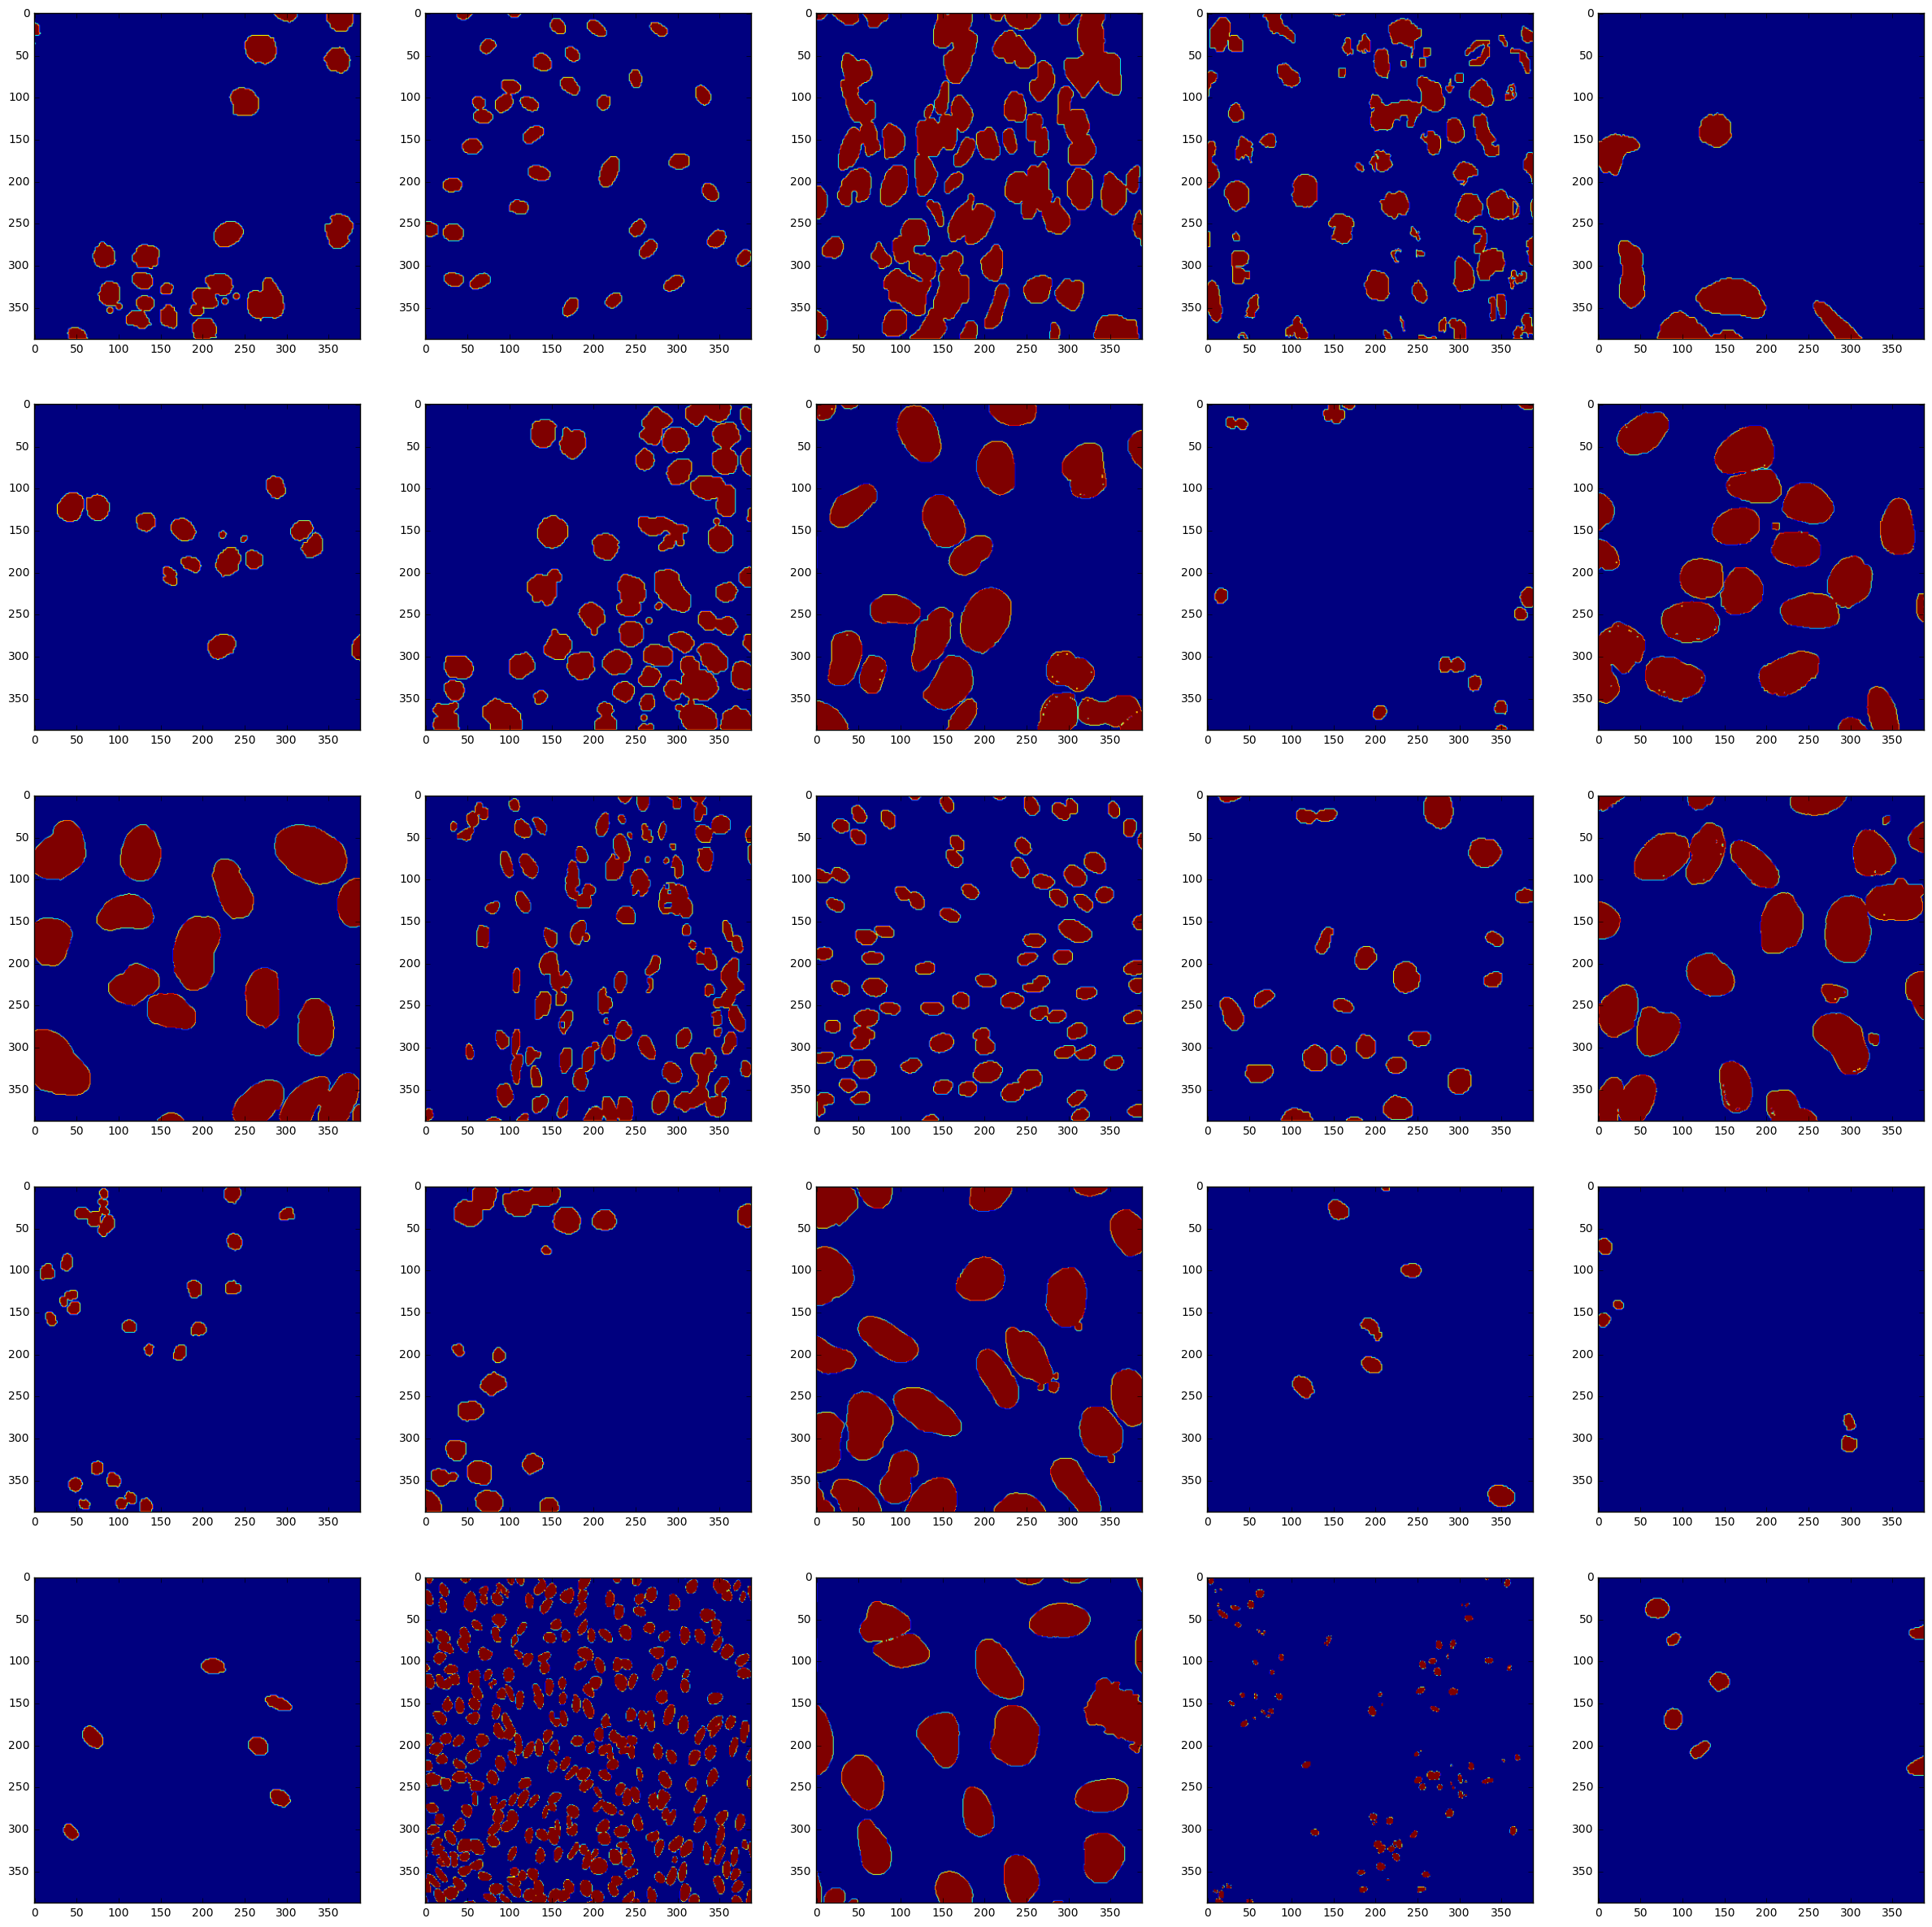

In [128]:
masks_array = [image['masks'] for image in images]
plot_images(rows=5,cols=5,images=masks_array)

In [129]:
Y_train = np.array(masks_array).reshape(670,mask_heigth,mask_width,1)
print(Y_train.shape)

(670, 388, 388, 1)


In [130]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Cropping2D, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [131]:
def model(height,width,channels):
    X_Input = Input(shape=(height,width,channels))
    X = Conv2D(filters=64, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X_Input)
    X = Conv2D(filters=64, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Dropout(0.2)(X)
    CX1 = Cropping2D(cropping=(88))(X)
    
    X = MaxPooling2D(pool_size=(2,2), strides=2)(X)
    X = Conv2D(filters=128, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)    
    X = Conv2D(filters=128, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Dropout(0.3)(X)
    CX2 = Cropping2D(cropping=(40))(X)
    
    X = MaxPooling2D(pool_size=(2,2), strides=2)(X)    
    X = Conv2D(filters=256, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Conv2D(filters=256, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Dropout(0.2)(X)
    CX3 = Cropping2D(cropping=(16))(X)
    
    X = MaxPooling2D(pool_size=(2,2), strides=2)(X)    
    X = Conv2D(filters=512, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Conv2D(filters=512, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Dropout(0.1)(X)
    CX4 = Cropping2D(cropping=(4))(X)
    
    X = MaxPooling2D(pool_size=(2,2), strides=2)(X)    
    X = Conv2D(filters=1024, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Conv2D(filters=1024, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Dropout(0.25)(X)
    
    X = Conv2DTranspose(filters=512, kernel_size=(2,2), strides=(2,2),activation='relu')(X)
    X = concatenate([X,CX4])
    X = Conv2D(filters=512, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Conv2D(filters=512, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Dropout(0.3)(X)
    
    X = Conv2DTranspose(filters=256, kernel_size=(2,2), strides=(2,2),activation='relu')(X)
    X = concatenate([X,CX3])
    X = Conv2D(filters=256, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Conv2D(filters=256, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Dropout(0.25)(X)
    
    X = Conv2DTranspose(filters=128, kernel_size=(2,2), strides=(2,2),activation='relu')(X)
    X = concatenate([X,CX2])
    X = Conv2D(filters=128, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Conv2D(filters=128, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Dropout(0.1)(X)
    
    X = Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2),activation='relu')(X)
    X = concatenate([X,CX1])
    X = Conv2D(filters=64, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    X = Conv2D(filters=64, kernel_size=(3,3),activation='relu', strides=(1,1), padding='valid')(X)
    
    X = Conv2D(filters=1, kernel_size=(3,3),activation='sigmoid', strides=(1,1), padding='same')(X)
    
    model = Model(input=X_Input, output=X)
    model.summary()
    
    return model

In [132]:
model = model(image_heigth,image_width,4)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           (None, 572, 572, 4)  0                                            
__________________________________________________________________________________________________
conv2d_621 (Conv2D)             (None, 570, 570, 64) 2368        input_46[0][0]                   
__________________________________________________________________________________________________
conv2d_622 (Conv2D)             (None, 568, 568, 64) 36928       conv2d_621[0][0]                 
__________________________________________________________________________________________________
dropout_284 (Dropout)           (None, 568, 568, 64) 0           conv2d_622[0][0]                 
__________________________________________________________________________________________________
max_poolin

/Users/lfawaz/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [133]:
model.compile(optimizer='adam',loss='binary_crossentropy')

In [134]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-2.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
592/603 [============================>.] - ETA: 4:27 - loss: 0.4344 
Epoch 00001: val_loss improved from inf to 0.38220, saving model to model-dsbowl2018-2.h5
603/603 [==============================] - 15165s 25s/step - loss: 0.4339 - val_loss: 0.3822
Epoch 2/50
592/603 [============================>.] - ETA: 4:25 - loss: 0.3971 
Epoch 00002: val_loss improved from 0.38220 to 0.37412, saving model to model-dsbowl2018-2.h5
603/603 [==============================] - 15097s 25s/step - loss: 0.3992 - val_loss: 0.3741
Epoch 3/50
592/603 [============================>.] - ETA: 4:21 - loss: 0.4008 
Epoch 00003: val_loss improved from 0.37412 to 0.37373, saving model to model-dsbowl2018-2.h5
603/603 [==============================] - 14815s 25s/step - loss: 0.4004 - val_loss: 0.3737
Epoch 4/50
592/603 [============================>.] - ETA: 4:20 - loss: 0.4005 
Epoch 00004: val_loss did not improve
603/603 [==============================]

In [15]:
from scipy import ndimage
from skimage.morphology import label

In [16]:
def separate_masks(combined_masks):
    labeled_masks = ndimage.label(combined_masks)
    masks = []
    for i in range(1,labeled_masks[1]+1):
        mask = (labeled_masks[0] == i).astype(int)
        masks.append(mask)
    
    return masks
    

In [17]:
def identify_postive_pixels(mask):
    mask = mask.T.flatten()
    positive_pixels = []
    for i in range(len(mask)):
        if(mask[i] == 1):
            positive_pixels.append(i+1)
        
    return positive_pixels

In [18]:
def encode_postive_pixels(postive_pixels):
    counter = 0
    EncodedPixels = []
    for i in range(len(pixels)):
        if(pixels[i] - 1 in pixels):
            counter += 1

        else:
            if(counter > 0):
                EncodedPixels.append(counter)
            EncodedPixels.append(pixels[i])
            counter = 0
    EncodedPixels.append(counter)
    return EncodedPixels